In [9]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

# import speicidfic models here
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

import shap


In [10]:
ticks = 5
target_base = 'Mid_Price_EMA_Short_z-score_normalised'
# target_base = 'Mid_Price_z-score_normalised'
split_type = 'time'


target_column  = 'Mid_Price_Future'
window_size = '1min'

In [11]:
# load dataset
def load_data():
    # df = pd.read_csv('data/lob/full_lob_head.csv', index_col=0)
    df = pd.read_parquet('data/output/full_normalised_lob_feature_set.parquet')
    return df

In [12]:
# preprocessing steps
def convert_timestamp(df):
    df['Timestamp'] = pd.to_numeric(df['Timestamp'])
    return df

def sort_values(df):
    df.sort_values(by=['Date','Timestamp'], inplace=True)
    return df

def pivot_table(df):
    df = df.pivot_table(index=['Timestamp', 'Exchange', 'Date'], 
                            columns='Order Type', 
                            values=['Price', 'Quantity'])
    df = df.reset_index()
    return df

def flatten_columns(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

def apply_window(df):
     # convert 'Timestamp' to a timedelta and add it to 'Date' to get a datetime
    df['Datetime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Timestamp'], unit='s')

    # set datetime as the index
    df.set_index('Datetime', inplace=True)

    # drop Exchange, Timestamp and Date columns
    df.drop(['Exchange', 'Timestamp', 'Date'], axis=1, inplace=True)

    df = df.resample(window_size).agg({
    'Price Ask': 'mean',
    'Price Bid': 'mean',
    'Quantity Ask': 'mean',
    'Quantity Bid': 'mean'
    })
    return df

def calculate_mid_price(df):
    df['Mid_Price'] = (df['Price Ask'] + df['Price Bid']) / 2
    return df

def market_price_spread(df):
    df['mean_market_spread'] = df['Price Ask'] - df['Price Bid']
    return df

def market_quantity_spread(df):
    df['mean_quantity_spread'] = df['Quantity Ask'] - df['Quantity Bid']
    return df

def create_lag_features(df):
    df['Mid_Price_Future'] = df[target_base].shift(-ticks)
    # drop the last 'ticks' rows
    df = df[:-ticks]
    df = df.dropna()
    df = df.drop(columns=['Timestamp', 'Exchange', 'Bid', 'Ask'])
    print(df.info())
    return df

def create_hist_features(df):
    for i in range(1, ticks+1):
        df[f'Mid_Price_Past_{i}'] = df[target_base].shift(i)
    # drop the first 'ticks' rows
    df = df[ticks:]
    return df

def log_transform(df):
    # apply log transform to df['Mid_Price_Future']
    df['Mid_Price_Future'] = np.log(df['Mid_Price_Future'] + 0.0001)
    # Replace -inf with large negative number
    df['Mid_Price_Future'] = df['Mid_Price_Future'].replace(-np.inf, -1e10)
    return df

def split_data(df):
    X = df.drop(columns=[target_column])
    X = X.drop(columns=['Date'])

    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def split_data_temporal(df):
    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Convert 'Date' to timestamp (numeric format)
    df['Date'] = df['Date'].map(datetime.datetime.timestamp)

    split_point = df['Date'].quantile(0.8)
    X_train = df[df['Date'] < split_point].drop(columns=[target_column])
    y_train = df[df['Date'] < split_point][target_column]
    X_test = df[df['Date'] >= split_point].drop(columns=[target_column])
    y_test = df[df['Date'] >= split_point][target_column]
    
    feature_indices = [38, 37, 21, 40, 11, 8, 29, 41, 10, 23, 31, 25, 28, 24]

    X_train = X_train.iloc[:, feature_indices]
    X_test = X_test.iloc[:, feature_indices]

    print(X_train.info())

    return X_train, X_test, y_train, y_test

def preprocess_data(df):
    if split_type == 'time':
        return (df.pipe(convert_timestamp)
                  .pipe(sort_values)
                  .pipe(create_lag_features)
                  .pipe(create_hist_features)
                  .pipe(split_data_temporal)
                )
    else:
        return (df.pipe(convert_timestamp)
                .pipe(sort_values)
                .pipe(create_lag_features)
                .pipe(create_hist_features)
                .pipe(split_data)
                )

In [13]:
# model pipeline
def test_model(model, X_train, X_test, y_train, y_test):
    # Define pipeline steps
    steps = [
        # ('scaler', StandardScaler()),  # Feature scaling
        ('model', model)  # Classifier/regressor model
    ]
    
    # Create pipeline
    pipeline = Pipeline(steps)
    
    # Train the model
    # pipeline.fit(X_train, y_train)

    # run bootstrap
    n_iterations = 1  # number of bootstrap samples to create
    mse_stats = list()
    r2_stats = list()
    for i in range(n_iterations):
        # prepare train and test sets
        X_train_resample, y_train_resample = resample(X_train, y_train)
        
        pipeline.fit(X_train_resample, y_train_resample)
        
        # evaluate model
        predictions = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, predictions, squared=False)
        r2 = r2_score(y_test, predictions)
        
        mse_stats.append(mse)
        r2_stats.append(r2)

    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower_mse = np.percentile(mse_stats, p)
    upper_mse = np.percentile(mse_stats, 100 - p)
    lower_r2 = np.percentile(r2_stats, p)
    upper_r2 = np.percentile(r2_stats, 100 - p)

    print('%.1f confidence interval for MSE %.1f and %.1f' % (alpha*100, lower_mse, upper_mse))
    print('%.1f confidence interval for R^2 %.3f and %.3f' % (alpha*100, lower_r2, upper_r2))
        
    # predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # evaluate model performance
    # calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')

    # calculate R^2 score
    r2 = r2_score(y_test, y_pred)
    print(f'R^2 Score: {r2}')

    # add a line to a csv file saving the model performance
    with open('model_performance.csv', 'a') as f:
        f.write(f'{"XGB"},{ticks},{target_base},{split_type},{mse},{r2},"plots/parity_plot{ticks}{target_base}{split_type}.png"\n')

    # parity plot
    # plt.figure(figsize=(8, 8))
    # plt.scatter(y_test, y_pred, alpha=0.3)
    # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    # plt.xlabel('Actual')
    # plt.ylabel('Predicted')
    # plt.title('Parity plot')
    # # save plot 
    # plt.savefig(f'plots/parity_plot{ticks}{target_base}{split_type}.png')

    # plt.show()

    # fig, ax = plt.subplots()

    # h = ax.hexbin(y_test, y_pred, gridsize=20, cmap='Greys')

    # ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    # ax.set_xlabel('Actual')
    # ax.set_ylabel('Predicted')
    # ax.set_title('Parity plot')
    # fig.colorbar(h)


    # create an explainer object
    explainer = shap.Explainer(model)

    # calculate SHAP values
    shap_values = explainer.shap_values(X_train)

    # plot the SHAP summary plot
    shap.summary_plot(shap_values, X_train)

    # get feature importance
    importance = model.feature_importances_

    # pair feature names with their importance scores
    features_scores = list(zip(range(len(importance)), importance))

    # sort by score in descending order
    sorted_features_scores = sorted(features_scores, key=lambda x: x[1], reverse=True)

    # print sorted feature importance
    for feature, score in sorted_features_scores:
        print(f'Feature: {feature}, Score: {score}')
    
    # additional evaluation metrics or visualizations can be added here
    
    # return the trained pipeline
    model.save_model('models/5shift-reduced-features2.xgb')
    
    return pipeline

In [14]:
# main function to run the pipeline
def main():
    # load data
    data = load_data()
    # preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(data)

    # models = {
    #     # models go here
    #     # "Support Vector Machine": SVC(),
    #     # "Linear Regression": LinearRegression(),
    #     # "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    #     "XGBoost": xgb.XGBRegressor()
    # }

    # best parameters from Sagemaker Auto ML
    
    model = xgb.XGBRegressor(
        alpha=4.4896022440326026e-06,
        colsample_bytree=0.42580889436201175,
        eta=0.22769029763766693,
        gamma=0.0007355643156605762,
        max_depth=8,
        min_child_weight=0.001477576788466928
    )

    pipeline = test_model(model, X_train, X_test, y_train, y_test)
        
        # todo: Perform cross-validation
        # cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
        # print("Cross-validation scores:", cv_scores)
        
        # todo: Hyperparameter tuning using GridSearchCV
        # param_grid = {...}
        # grid_search = GridSearchCV(pipeline, param_grid, cv=5)
        # grid_search.fit(X_train, y_train)
        # best_params = grid_search.best_params_
        # print("Best hyperparameters:", best_params)
        
        # todo: Save the best model
        # best_model = grid_search.best_estimator_
        # Save the best_model for future use

<class 'pandas.core.frame.DataFrame'>
Index: 32262836 entries, 22871615 to 7557017
Data columns (total 41 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   Date                                           object 
 1   Mid_Price_Raw                                  float64
 2   Mid_Price_EMA_Raw                              float64
 3   Unnamed: 0_z-score_normalised                  float64
 4   Mid_Price_z-score_normalised                   float64
 5   Total_Order_Volume_z-score_normalised          float64
 6   OBV_z-score_normalised                         float64
 7   Total_Volume_Imbalance_z-score_normalised      float64
 8   Order_Imbalance_z-score_normalised             float64
 9   Weighted_Mid_Price_z-score_normalised          float64
 10  Bid_Ask_Spread_z-score_normalised              float64
 11  Level_1_Bid_Price_z-score_normalised           float64
 12  Level_1_Ask_Price_z-score_normalised   

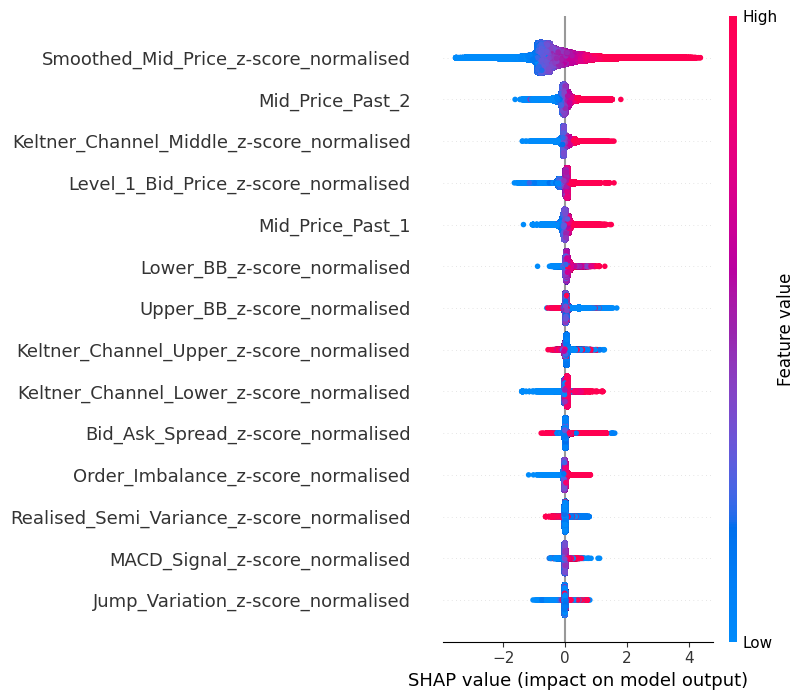

Feature: 0, Score: 0.46857479214668274
Feature: 3, Score: 0.25569915771484375
Feature: 7, Score: 0.18116779625415802
Feature: 9, Score: 0.03502625599503517
Feature: 8, Score: 0.027775313705205917
Feature: 12, Score: 0.008251332677900791
Feature: 6, Score: 0.006685182917863131
Feature: 10, Score: 0.005630706902593374
Feature: 4, Score: 0.004114916082471609
Feature: 5, Score: 0.0019962105434387922
Feature: 11, Score: 0.0015739966183900833
Feature: 13, Score: 0.001556564588099718
Feature: 1, Score: 0.0011668663937598467
Feature: 2, Score: 0.0007808934897184372


In [15]:
main()

In [16]:
 shap.summary_plot(shap_values, X_train)

NameError: name 'shap_values' is not defined